In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

# define threshold of popular support for major parties:
MAJ_PARTY_THRESH=0.05

In [2]:
WORKDIR = os.getcwd()
Vote_data_path = "./source_data/DL_BE_AB2016_V2_formatted.txt"

In [3]:
Data_RAW = pd.read_csv( Vote_data_path, 
                        sep="\t",
                        header=0 )

In [12]:
Data_RAW.shape

(2432, 43)

In [13]:
#Data_RAW.head

In [14]:
# first index corresponding to a party's vote tally is 17, continues in decreasing order of total votes.
party_names_all = Data_RAW.columns[17:]
print(party_names_all)

Index(['SPD', 'CDU', 'GRÜNE', 'LINKE', 'PIRATEN', 'NPD', 'FDP',
       'Tierschutzpartei', 'pro.Deutschland', 'DiePARTEI', 'BIG', 'DKP', 'ödp',
       'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD',
       'DIE.EINHEIT', 'DIE.VIOLETTEN', 'Graue.Panther', 'MENSCHLICHE.WELT',
       'MIETERPARTEI', 'Gesundheits.forschung'],
      dtype='object')


In [15]:
# total number of regional ridings:
n_ridings     = Data_RAW.shape[0]
n_parties_all = Data_RAW.shape[1]-17
print( n_ridings )
print( n_parties_all )

2432
26


In [16]:
# cross-check that the sum of all party votes adds up to the "valid" column
assert max(abs([sum( Data_RAW.values[n,17:]) for n in range(n_ridings) ] -  Data_RAW.values[:,16])) == 0

In [17]:
# separate ridings into "Urnen" (ballot box) Bezirks, and "Brief" (mail-in ballot) bezirks
Data_Urn   = Data_RAW.set_index("Wahlbezirksart").loc["Urnenwahlbezirk"]
Data_Brief = Data_RAW.set_index("Wahlbezirksart").loc["Briefwahlbezirk"]

In [18]:
votes_RAW= Data_RAW.values[:,17:]
print(votes_RAW.shape)

(2432, 26)


In [19]:
party_votes = [ sum( votes_RAW[:,n]) for n in range(n_parties_all) ]
Total_votes_allparties = sum(party_votes)
print( Total_votes_allparties )

1635169


In [22]:
party_voteshare = [ party_votes[n]/Total_votes_allparties for n in range(n_parties_all) ]
# print( party_voteshare )
major_parties = [ party_names_all[p] for p in range(n_parties_all) if party_voteshare[p]> MAJ_PARTY_THRESH ]
minor_parties = list( party_names_all.difference( major_parties ) )

N_major_parties = len(major_parties)
print( "Major parties : "); print( major_parties )
print( "Minor parties : "); print( minor_parties )

Major parties : 
['SPD', 'CDU', 'GRÜNE', 'LINKE', 'FDP', 'AfD']
Minor parties : 
['ALFA', 'B', 'BIG', 'BüSo', 'DIE.EINHEIT', 'DIE.VIOLETTEN', 'DKP', 'DL', 'DiePARTEI', 'Gesundheits.forschung', 'Graue.Panther', 'MENSCHLICHE.WELT', 'MIETERPARTEI', 'NPD', 'PIRATEN', 'PSG', 'Tierschutzallianz', 'Tierschutzpartei', 'pro.Deutschland', 'ödp']


In [23]:
 # ==========================================================================================================

In [25]:
# ====== we will work primarily with the "Urn" data (since there are many more of them)
# we'll come back to the Brief data later to check for robustness.

In [132]:
N_urn_ridings = Data_Urn.shape[0]
print( N_urn_ridings )

1779


In [55]:
# Select just the major parties:
Data_urn_major         = Data_Urn[major_parties]
Data_urn_major.index   = range( Data_urn_major.shape[0] )


# === add up the "invalid" votes with the votes for all "other" parties into a separate column 
Other=pd.DataFrame( { "Other": [sum((Data_Urn[minor_parties+["invalid"]]).values[n,:]) 
                                         for n in range(Data_Urn.shape[0]) ] } )

# Create a df with just these "parties"
Data_urn_filtered = pd.merge( Data_urn_major, 
                              Other, 
                              left_index=True, 
                              right_index=True ) 

In [162]:
# isolate an O-W list
Data_Urn_OW_list = Data_Urn["OstWest"]
Data_Urn_OW_list.index  = range( len(Data_Urn_OW_list)  )
Data_Urn_OW_list

0       W
1       O
2       O
3       O
4       O
       ..
1774    W
1775    W
1776    W
1777    W
1778    W
Name: OstWest, Length: 1779, dtype: object

In [312]:
# Normalize vote-shares
Data_urn_normed  = Data_urn_filtered.copy()
for i in range( Data_urn_normed.shape[0] ):
    Data_urn_normed.loc[i] = Data_urn_normed.loc[i] / sum( Data_urn_normed.loc[i] ) 

In [313]:
Data_urn_majp_normed  = Data_urn_filtered.copy()[major_parties]
for i in range( Data_urn_majp_normed.shape[0] ):
    Data_urn_majp_normed.loc[i] = Data_urn_majp_normed.loc[i] / sum( Data_urn_majp_normed.loc[i] ) 

In [183]:
# Get the mean positions of each of the groups
meanpoint_Ost  = np.mean( Data_urn_normed.loc[ Data_Urn_OW_list =="O"  ] )
meanpoint_West = np.mean( Data_urn_normed.loc[ Data_Urn_OW_list =="W"  ] )

# And define a vector pointint in the direction from one to the other.
OW_vec = (meanpoint_Ost - meanpoint_West)/np.linalg.norm( meanpoint_Ost - meanpoint_West ) 

print (np.linalg.norm( OW_vec ))

1.0


(array([ 9., 17., 21., 42., 37., 40., 43., 35., 36., 44., 38., 45., 46.,
        48., 36., 43., 34., 33., 32., 28., 31., 37., 28., 26., 34., 30.,
        21., 22., 24., 19., 21., 24., 28., 17., 28., 17., 12., 18., 22.,
        13., 24., 26., 18., 28., 19., 17.,  9.,  9., 16., 14.,  9., 19.,
         8., 15.,  9., 15., 16., 11., 15., 19., 17., 16., 19., 16., 16.,
        12.,  8.,  8., 11.,  4., 13.,  8.,  8., 15.,  4.,  5.,  9., 14.,
         4.,  8.,  8., 12.,  3.,  4.,  6.,  4.,  6.,  3.,  3.,  2.,  3.,
         3.,  1.,  2.,  3.,  0.,  2.,  1.,  1.,  2.]),
 array([0.01876676, 0.0226478 , 0.02652885, 0.0304099 , 0.03429095,
        0.038172  , 0.04205305, 0.0459341 , 0.04981514, 0.05369619,
        0.05757724, 0.06145829, 0.06533934, 0.06922039, 0.07310144,
        0.07698248, 0.08086353, 0.08474458, 0.08862563, 0.09250668,
        0.09638773, 0.10026878, 0.10414982, 0.10803087, 0.11191192,
        0.11579297, 0.11967402, 0.12355507, 0.12743611, 0.13131716,
        0.13519821, 0.1390

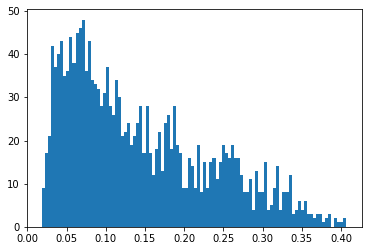

In [134]:
plt.hist( Data_urn_normed["GRÜNE"], 
           bins = 100 )

In [102]:
Data_urn_normed["GRÜNE"] > 0.2

0       False
1       False
2        True
3        True
4        True
        ...  
1774     True
1775    False
1776    False
1777    False
1778    False
Name: GRÜNE, Length: 1779, dtype: bool

In [317]:
Data_urn_nparr     = Data_urn_normed.values
pca  = PCA()
Data_urn_nparr_PCs = pca.fit_transform(Data_urn_nparr)

Data_urn_majp_nparr = Data_urn_majp_normed.values 
pca_majp = PCA()
Data_urn_nparr_majp_PCs = pca.fit_transform( Data_urn_majp_nparr )

In [320]:
Data_urn_nparr_majp_PCs.shape
# pca.transform(OW_vec.transpose)

(1779, 6)

In [114]:
# confirm that the norm-distances between points is invariant
def normdiff( Dat, i, j):
    return math.sqrt( sum( (Dat[i,:] - Dat[j,:])**2 ) )
# confirm that absdiffs are unchanged
print( normdiff( Data_urn_nparr, 520 , 21) )
print( normdiff( Data_urn_nparr_PCs, 520 , 21) )

0.29253947298905303
0.2925394729890528


In [316]:
# Data_urn_normed

In [150]:
# 
Winner_list = [ np.argmax( Data_urn_normed.iloc[n].values) for n in  range(N_urn_ridings) ]
len(Winner_list)

1779

In [307]:
# Gwinner_OW_ccode 

In [202]:
# Data_Urn["OstWest"].values
OW_ccode       = [ "blue"  if x=="W" else "red"   for x in Data_Urn["OstWest"].values ]
Go20pc_ccode   = [ "green" if x>0.2  else "black" for x in Data_urn_normed["GRÜNE"]   ]
Gwinner_ccode  = [ "green" if x==2   else "black" for x in Winner_list ]


Gwinner_OW_ccode  = [ "green" if Winner_list[x]==2 
                       else "blue" if Data_Urn["OstWest"].values[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

Go20pc_OW_ccode  = [ "green" if Data_urn_normed["GRÜNE"][x] >0.2 
                       else "blue" if Data_Urn["OstWest"].values[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

# both_ccode =  [ "green" if Data_urn_normed["GRÜNE"][x]>0.2  else OW_ccode[x] for x in len(Data_urn_normed["GRÜNE"]) ]

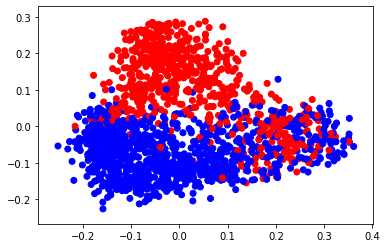

In [326]:
plt.scatter( Data_urn_nparr_majp_PCs[:, 0], 
             Data_urn_nparr_majp_PCs[:, 1],
             c= ccode );

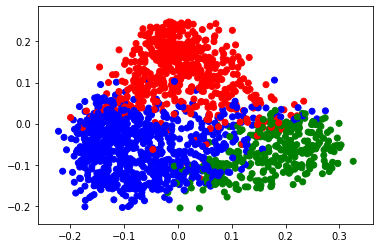

In [204]:
plt.scatter( Data_urn_nparr_PCA[:, 0], 
             Data_urn_nparr_PCA[:, 1],
             c = Gwinner_OW_ccode );

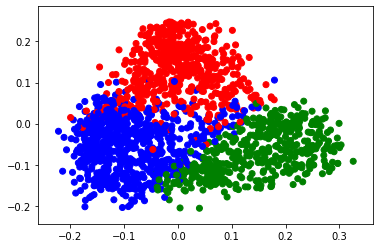

In [205]:
plt.scatter( Data_urn_nparr_PCA[:, 0], 
             Data_urn_nparr_PCA[:, 1],
             c = Go20pc_OW_ccode );

In [211]:
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=2)
kmeans_3 = KMeans(n_clusters=3)

kmeans_2.fit(Data_urn_nparr)
kmeans_3.fit(Data_urn_nparr)

kmeans_2.predict(Data_urn_nparr)

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [221]:
km    = KMeans( n_clusters=3 )
km.fit( Data_urn_nparr)
temp = km.predict(Data_urn_nparr)

In [292]:
def calc_percW(OWarray, kMeansarray, n):
    temp  = OWarray[ kMeansarray == n ]
    tempW = temp[temp=="W"]
    return (len(tempW)/len(temp))

def cleanclusters( k, Dat, OWarray ):
    # automate clustering, but ensure a standardized convention so that the "west" block is always 0, East 1.
    km = KMeans( n_clusters=k )
    km.fit(Dat)
    clusters = km.predict( Dat )
    # this is now an array of cluster value assignments 0..k, but the values are arbitrary and randomly assigned.
    # Now put them in order of "W" percentage so that they can be referred to consistently.
    
    percW     = [ calc_percW(OWarray, clusters,n) for n in set(clusters) ]   
    arb_order = sorted( [ x[::-1] for x in enumerate(percW) ] )[::-1]
    # This is a set of tuples, the latter value of which indicates the arbitrary label, which we now reassign
    
    # Now re-order the entries in the _copy set
    clusters_ordered = clusters.copy()

    for i in range(len(percW)):
        clusters_ordered [ clusters == arb_order[i][1] ] = i
       
    return clusters_ordered 

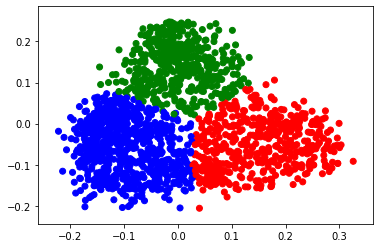

In [337]:
clust        = cleanclusters(3, Data_urn_normed, Data_Urn["OstWest"].values )
clust_ccode  = [ "blue" if x==0 else "red" if x==1 else "green" for x in clust ]


plt.scatter( Data_urn_nparr_PCs[:, 0], 
             Data_urn_nparr_PCs[:, 1],
             c = clust_ccode );


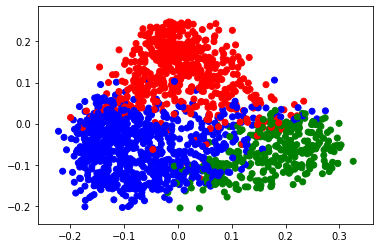

In [345]:
ytarget_Gw_OW = [ 2 if Winner_list[x]==2 
                  else 0 if Data_Urn["OstWest"].values[x]=="W" 
                  else 1 
                     for x in range(len(Winner_list)) ] 
target_Gw_OW_ccode  = [ "blue" if x==0 else "red" if x==1 else "green" for x in ytarget ]


ytarget_Go20pc_OW  = [ 2 if Data_urn_normed["GRÜNE"][x] >0.2 
                            else 0 if Data_Urn["OstWest"].values[x]=="W" 
                            else 1 
                               for x in range(len(Winner_list)) ]
target_Go20pc_OW_ccode  = [ "blue" if x==0 else "red" if x==1 else "green" for x in ytarget ]


plt.scatter( Data_urn_nparr_PCs[:, 0], 
             Data_urn_nparr_PCs[:, 1],
             c = target_Gw_OW_ccode );

In [340]:
ytarget

[0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
